In [1]:
import sys
sys.path.append("../")
from dropkick import *

/Users/cody/.virtualenvs/qc/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/cody/.virtualenvs/qc/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
import glmnet

In [3]:
print(glmnet.__version__)

2.1.1+1.gf2dac4f.dirty


In [4]:
a = sc.read("../data/2771-AS-1-GCCAAT_S1.h5ad")

In [5]:
recipe_dropkick(a, X_final="arcsinh_norm")

Calculating metrics:
Top 10 ambient genes have dropout rates between 0.14 and 3.56 percent:
	['mt-Co2', 'mt-Co1', 'mt-Cytb', 'mt-Atp6', 'mt-Nd1', 'mt-Nd4', 'Gm42418', 'mt-Co3', 'mt-Nd2', 'mt-Nd3']
Determining 2000 highly variable genes


In [6]:
a_thresh = auto_thresh_obs(a, method="otsu", obs_cols=["arcsinh_n_genes_by_counts", "pct_counts_ambient"])

# create labels from combination of thresholds
filter_thresh_obs(
    a,
    a_thresh,
    obs_cols=["arcsinh_n_genes_by_counts", "pct_counts_ambient"],
    directions=["above", "below"],
    inclusive=True,
    name="train",
)

In [7]:
y = a.obs["train"].copy(deep=True)

In [8]:
lr = LogitNet(alpha=0.1, n_splits=3, n_lambda=10, n_jobs=4)

In [9]:
%time lr.fit(adata=a, y=y, n_hvgs=2000)

CPU times: user 1min 3s, sys: 7.37 s, total: 1min 10s
Wall time: 40.2 s


LogitNet(alpha=0.1, cut_point=1.0, fit_intercept=True, lambda_path=None,
         lower_limits=-inf, max_features=None, max_iter=100000,
         min_lambda_ratio=0.0001, n_jobs=4, n_lambda=10, n_splits=3,
         random_state=None, scoring=None, standardize=True, tol=1e-07,
         upper_limits=inf, verbose=False)

In [11]:
lr.coef_.shape

(1, 2000)

In [12]:
lr.lambda_max_

0.023716532851722358

In [13]:
lr.lambda_best_

array([0.06599266])

In [14]:
lr.lambda_path_

array([1.42176879e+00, 5.10957211e-01, 1.83628501e-01, 6.59926615e-02,
       2.37165329e-02, 8.52327998e-03, 3.06310801e-03, 1.10082394e-03,
       3.95615612e-04, 1.42176879e-04])

In [15]:
lr.cv_mean_score_

array([0.65079366, 0.74863709, 0.84709746, 0.88789704, 0.89000573,
       0.87822493, 0.8627244 , 0.8453631 , 0.83482261, 0.83209462])

In [18]:
X = a.X[:, a.var.highly_variable].copy()

In [19]:
lr.score(X, y)

array(0.89347718)

In [70]:
a.X = a.layers["log1p_norm"].copy()

In [72]:
test = sc.pp.highly_variable_genes(a, n_top_genes=2000, flavor="seurat", inplace=False)

In [75]:
[x[0] for x in test]

[False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,

In [13]:
adata = a[:,a.var.highly_variable].copy()

In [21]:
a.obs["logitnet_score"] = lr.predict_proba(X)[:, 1]

In [22]:
a.obs["logitnet_label"] = lr.predict(X)

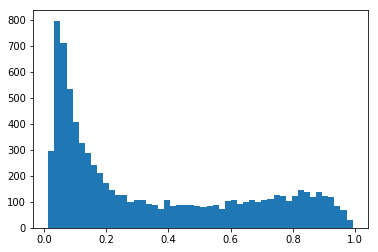

In [23]:
# distribution of scores should be bimodal at 0 and 1
_ = plt.hist(a.obs['logitnet_score'], bins=50)

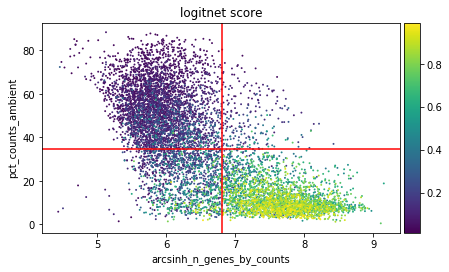

In [24]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=a, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='logitnet_score', show=False)
ax.axvline(a_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(a_thresh['pct_counts_ambient'], color='r')
plt.show()

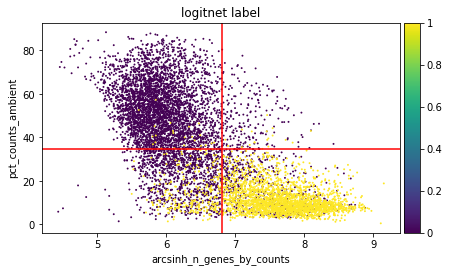

In [25]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=a, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='logitnet_label', show=False)
ax.axvline(a_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(a_thresh['pct_counts_ambient'], color='r')
plt.show()

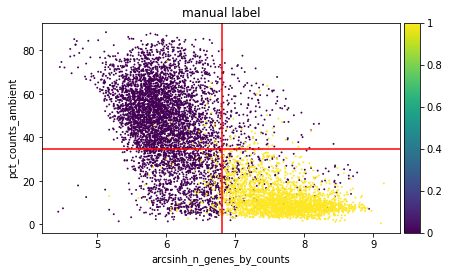

In [26]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=a, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='manual_label', show=False)
ax.axvline(a_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(a_thresh['pct_counts_ambient'], color='r')
plt.show()

In [27]:
a.var.loc[a.var.highly_variable, "dropkick_coef"] = lr.coef_.squeeze()

In [28]:
from qc_test import *

In [29]:
coef_inventory(a)


Top HVGs by coefficient value (good cells):
index
Cd74       0.286987
Mpeg1      0.184021
Ctsc       0.157565
Mzb1       0.156313
Cd79a      0.146577
Tmem123    0.143081
Slpi       0.135726
Suclg1     0.131886
Snx3       0.131392
Hsd11b2    0.116066
Name: dropkick_coef, dtype: float64

Bottom HVGs by coefficient value (bad droplets):
index
Zg16      -0.196903
Apoe      -0.059716
Hormad2   -0.026936
Mmp12     -0.020345
Strn3     -0.017844
Vimp      -0.014417
Gm37504   -0.014391
Gm28151   -0.013653
Gm26917   -0.011574
Gm11690   -0.009007
Name: dropkick_coef, dtype: float64

1597 coefficients equal to zero. Model sparsity: 79.85 %



In [32]:
set_diff(a, ['manual_label','logitnet_label'], metrics=["arcsinh_n_genes_by_counts","arcsinh_total_counts","pct_counts_ambient","pct_counts_mito"])

2715 cells in manual_label - 540 unique
	arcsinh_n_genes_by_counts: 7.64
	arcsinh_total_counts: 8.46
	pct_counts_ambient: 12.5
	pct_counts_mito: 12.5
2595 cells in logitnet_label - 420 unique
	arcsinh_n_genes_by_counts: 7.56
	arcsinh_total_counts: 8.32
	pct_counts_ambient: 12.1
	pct_counts_mito: 12.1


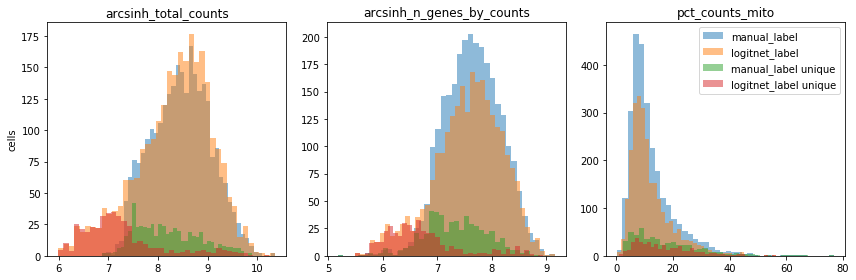

In [33]:
plot_set_obs(a, ['manual_label','logitnet_label'])